**IMPORT LIBRARY**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.decomposition import PCA
import joblib

In [2]:
# Business Understanding
print("Tujuan: Memprediksi penyakit paru-paru berdasarkan gaya hidup dan penyakit bawaan.")

Tujuan: Memprediksi penyakit paru-paru berdasarkan gaya hidup dan penyakit bawaan.


**LOAD DATASET**

In [3]:
# 1. Load Dataset
df = pd.read_csv('/content/predic_tabel.csv')

**EDA**

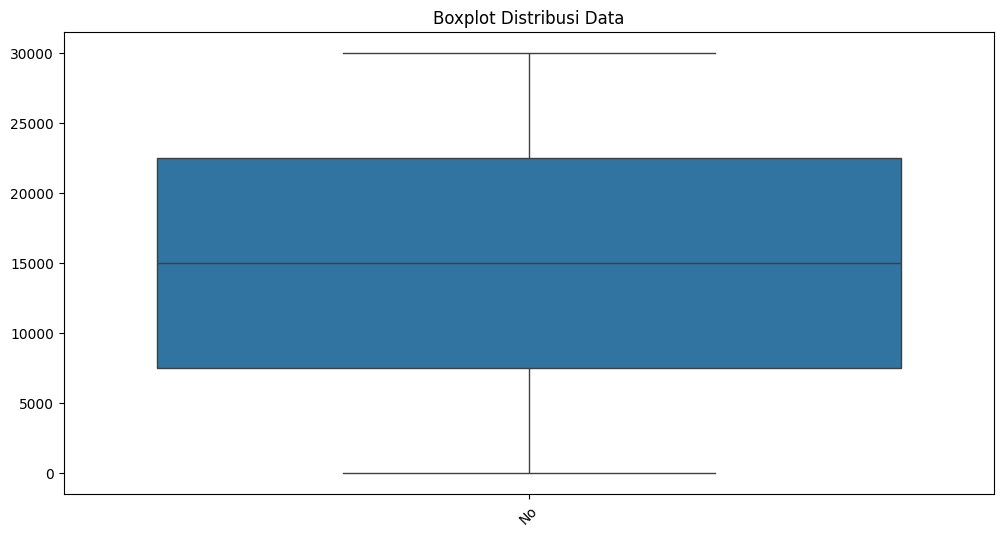

In [4]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df)
plt.title("Boxplot Distribusi Data")
plt.xticks(rotation=45)  # Memutar label sumbu x jika panjang
plt.show()

In [5]:
print(df.head())

   No  Usia Jenis_Kelamin Merokok Bekerja Rumah_Tangga Aktivitas_Begadang  \
0   1   Tua          Pria   Pasif   Tidak           Ya                 Ya   
1   2   Tua          Pria   Aktif   Tidak           Ya                 Ya   
2   3  Muda          Pria   Aktif   Tidak           Ya                 Ya   
3   4   Tua          Pria   Aktif      Ya        Tidak              Tidak   
4   5  Muda        Wanita   Pasif      Ya        Tidak              Tidak   

  Aktivitas_Olahraga Asuransi Penyakit_Bawaan  Hasil  
0             Sering      Ada           Tidak     Ya  
1             Jarang      Ada             Ada  Tidak  
2             Jarang      Ada           Tidak  Tidak  
3             Jarang      Ada             Ada  Tidak  
4             Sering    Tidak             Ada     Ya  


In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   No                  30000 non-null  int64 
 1   Usia                30000 non-null  object
 2   Jenis_Kelamin       30000 non-null  object
 3   Merokok             30000 non-null  object
 4   Bekerja             30000 non-null  object
 5   Rumah_Tangga        30000 non-null  object
 6   Aktivitas_Begadang  30000 non-null  object
 7   Aktivitas_Olahraga  30000 non-null  object
 8   Asuransi            30000 non-null  object
 9   Penyakit_Bawaan     30000 non-null  object
 10  Hasil               30000 non-null  object
dtypes: int64(1), object(10)
memory usage: 2.5+ MB
None


In [7]:
print(df.describe())

                 No
count  30000.000000
mean   15000.500000
std     8660.398374
min        1.000000
25%     7500.750000
50%    15000.500000
75%    22500.250000
max    30000.000000


In [8]:
print(df.isnull().sum())

No                    0
Usia                  0
Jenis_Kelamin         0
Merokok               0
Bekerja               0
Rumah_Tangga          0
Aktivitas_Begadang    0
Aktivitas_Olahraga    0
Asuransi              0
Penyakit_Bawaan       0
Hasil                 0
dtype: int64


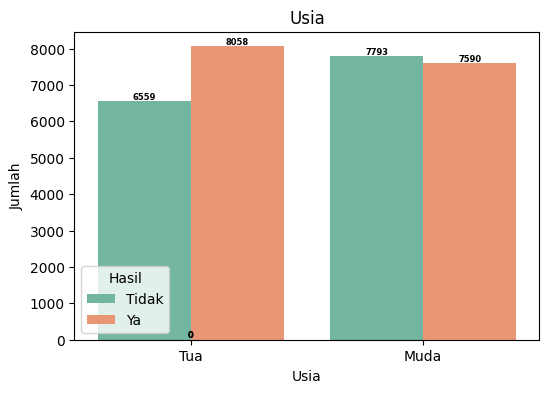

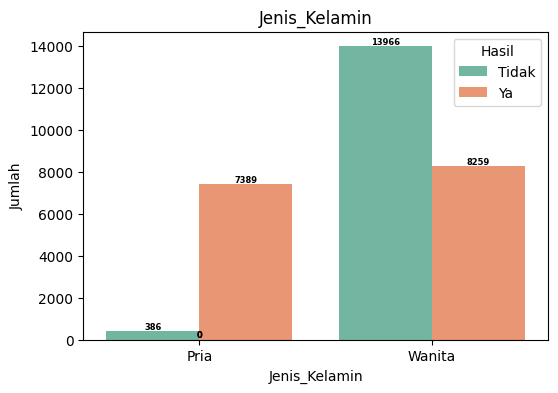

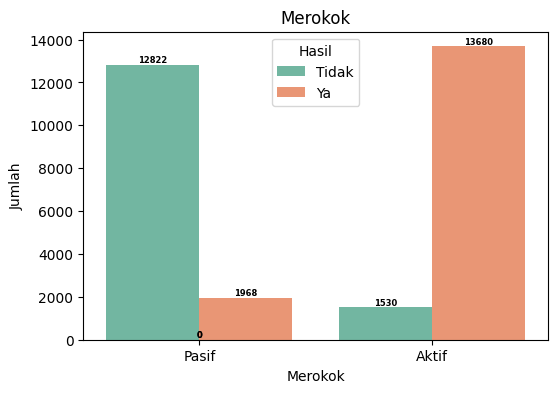

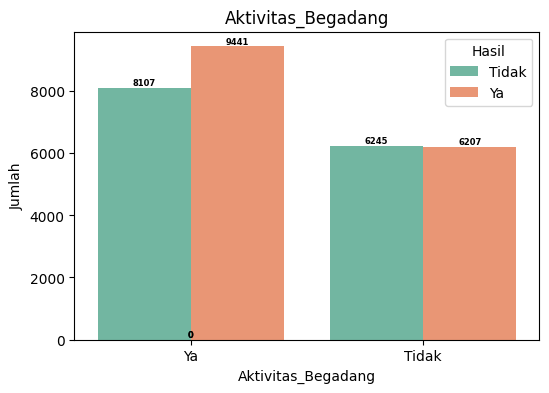

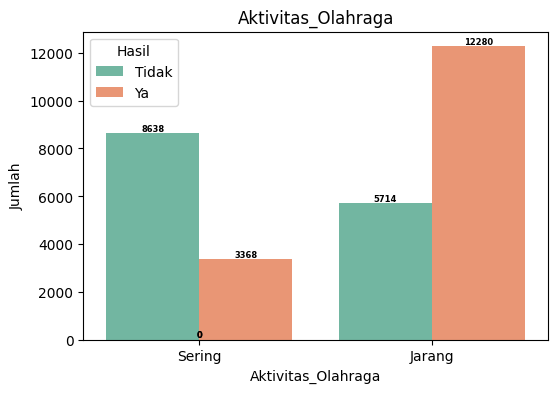

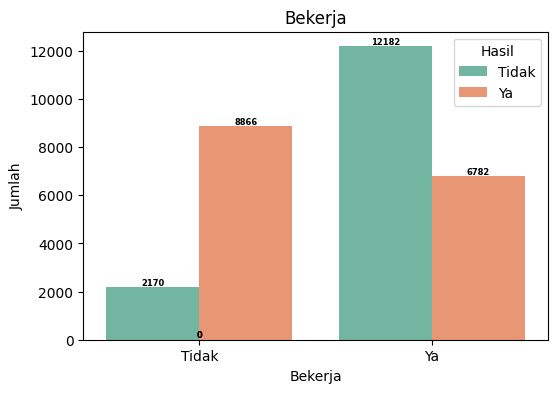

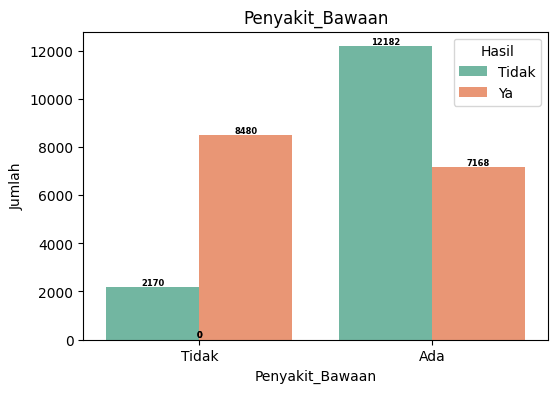

In [9]:
# Daftar fitur gaya hidup
lifestyle_features = ['Usia', 'Jenis_Kelamin', 'Merokok', 'Aktivitas_Begadang', 'Aktivitas_Olahraga', 'Bekerja', 'Penyakit_Bawaan']

# Loop untuk setiap fitur
for feature in lifestyle_features:
    plt.figure(figsize=(6, 4))

    # Buat count plot
    ax = sns.countplot(data=df, x=feature, hue='Hasil', palette='Set2')

    # Tambahkan nilai di atas setiap bar
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=6, color='black', fontweight='bold')

    # Atur judul dan label
    plt.title(f'{feature}')
    plt.xlabel(feature)
    plt.ylabel('Jumlah')
    plt.legend(title='Hasil', labels=['Tidak', 'Ya'])

    # Tampilkan plot
    plt.show()

**PREPROCESSING DATA**

*Data Cleaning*

In [10]:
# - Tangani nilai yang hilang
df.dropna(inplace=True)

In [11]:
print(df.isnull().sum())

No                    0
Usia                  0
Jenis_Kelamin         0
Merokok               0
Bekerja               0
Rumah_Tangga          0
Aktivitas_Begadang    0
Aktivitas_Olahraga    0
Asuransi              0
Penyakit_Bawaan       0
Hasil                 0
dtype: int64


*Data Duplication*

In [12]:
# Menampilkan duplikasi (baris yang berulang)
df.duplicated().sum()

np.int64(0)

*Data Transformation*

In [13]:
from sklearn.preprocessing import LabelEncoder
# Mengubah tipe data non-numerik sebelum korelasi
for col in df.select_dtypes(include=['object']).columns:
    df[col], _ = pd.factorize(df[col])

In [14]:
print(df.head())

   No  Usia  Jenis_Kelamin  Merokok  Bekerja  Rumah_Tangga  \
0   1     0              0        0        0             0   
1   2     0              0        1        0             0   
2   3     1              0        1        0             0   
3   4     0              0        1        1             1   
4   5     1              1        0        1             1   

   Aktivitas_Begadang  Aktivitas_Olahraga  Asuransi  Penyakit_Bawaan  Hasil  
0                   0                   0         0                0      0  
1                   0                   1         0                1      1  
2                   0                   1         0                0      1  
3                   1                   1         0                1      1  
4                   1                   0         1                1      0  


*Feature Selection*

In [15]:
# Atribut relevan
kolom_kategorikal = ['Usia', 'Jenis_Kelamin', 'Merokok', 'Aktivitas_Begadang', 'Aktivitas_Olahraga', 'Penyakit_Bawaan']

In [16]:
# Hapus atribut yang tidak relevan
df.drop(columns=['No', 'Asuransi', 'Rumah_Tangga', 'Bekerja'], inplace=True, errors='ignore')

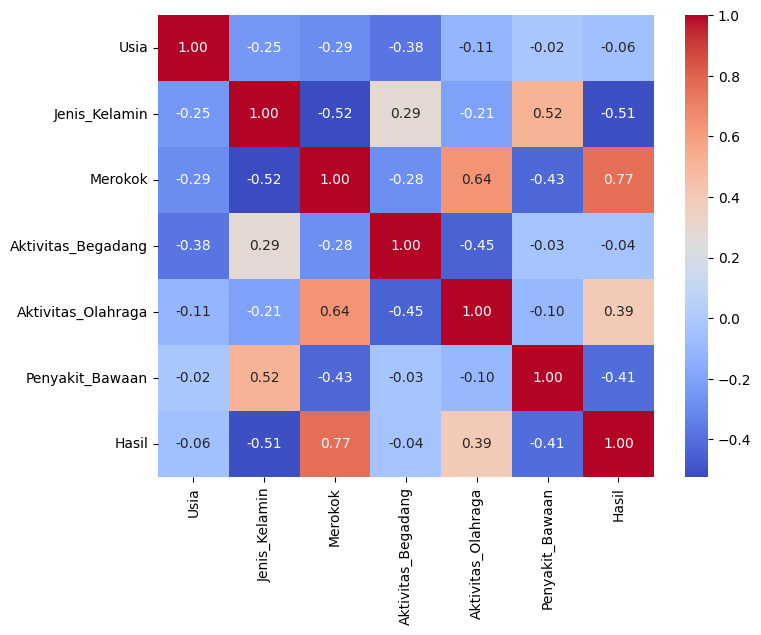

In [17]:
# Hitung korelasi antara fitur
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

*Splitting Data*

In [18]:
# Pisahkan fitur (X) dan target (y)
X = df.drop(columns=['Hasil'])
y = df['Hasil']

In [19]:
# Split data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

*Feature Scaling (Normalisasi/Standarisasi Data)*

In [20]:
# Standarisasi fitur
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

*PCA*

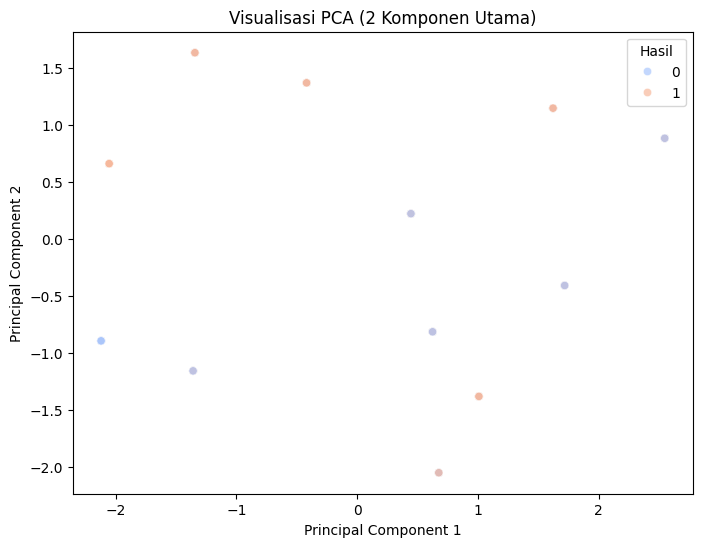

Variansi yang dijelaskan oleh PC1: 40.30%
Variansi yang dijelaskan oleh PC2: 23.74%
Total variansi yang dijelaskan oleh 2 PC: 64.04%


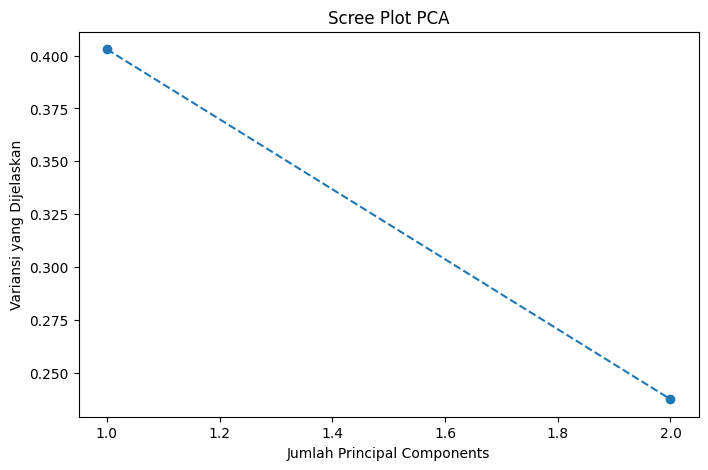

In [21]:
# Terapkan PCA
pca = PCA(n_components=2)  # Ambil 2 komponen utama untuk visualisasi
X_pca = pca.fit_transform(X_train_scaled)

# Konversi hasil PCA ke DataFrame
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["Hasil"] = y  # Tambahkan label target

# Visualisasi hasil PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="Hasil", palette="coolwarm", alpha=0.7)
plt.title("Visualisasi PCA (2 Komponen Utama)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Hasil")
plt.show()

# Cek kontribusi setiap komponen utama
explained_variance = pca.explained_variance_ratio_
print(f"Variansi yang dijelaskan oleh PC1: {explained_variance[0]:.2%}")
print(f"Variansi yang dijelaskan oleh PC2: {explained_variance[1]:.2%}")
print(f"Total variansi yang dijelaskan oleh 2 PC: {sum(explained_variance):.2%}")

# Visualisasi Scree Plot (Elbow Method)
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.xlabel("Jumlah Principal Components")
plt.ylabel("Variansi yang Dijelaskan")
plt.title("Scree Plot PCA")
plt.show()

**DATA MINING/MODELING**

*Model Training*

In [22]:
# Inisialisasi model Logistic Regression
logistic_model = LogisticRegression()

# Melatih model dengan data training yang sudah di-scale
logistic_model.fit(X_train_scaled, y_train)

LogisticRegression()

*Model Predictions*

In [23]:
# Model Prediction
y_pred = logistic_model.predict(X_test_scaled)
y_prob = logistic_model.predict_proba(X_test_scaled)[:, 1]

**EVALUATION**

*Cross Validation*

In [24]:
# Cross Validation dengan 5 lipatan
cv_scores = cross_val_score(logistic_model, X, y, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))

Cross-Validation Scores: [0.89566667 0.896      0.89566667 0.89533333 0.89533333]
Mean CV Accuracy: 0.8956


*Best* *Hyperparameters*

In [25]:
# Set parameter yang akan disesuaikan
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Inisialisasi model
logistic_model_tuned = LogisticRegression()

# GridSearchCV untuk penyetelan hiperparameter
grid_search = GridSearchCV(logistic_model_tuned, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Parameter terbaik
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Model dengan parameter terbaik
logistic_model_best = grid_search.best_estimator_

Best Hyperparameters: {'C': 1}


*Classification Report*

In [26]:
# Model Evaluation
akurasi = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
print("Akurasi:", akurasi)
print("ROC-AUC Score:", roc_auc)
print("Laporan Klasifikasi:")
print(classification_report(y_test, y_pred))

Akurasi: 0.8928333333333334
ROC-AUC Score: 0.9693219373219373
Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       1.00      0.78      0.88      2925
           1       0.83      1.00      0.91      3075

    accuracy                           0.89      6000
   macro avg       0.91      0.89      0.89      6000
weighted avg       0.91      0.89      0.89      6000



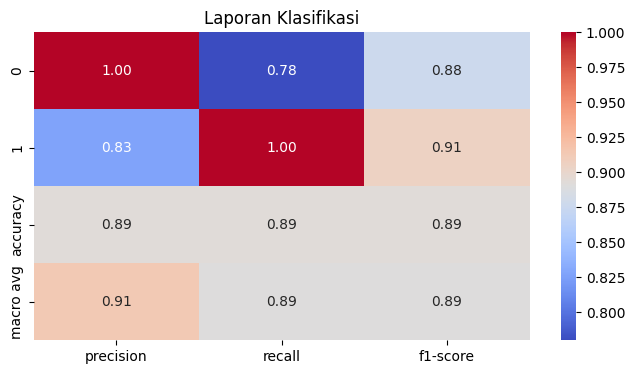

In [27]:
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
plt.figure(figsize=(8, 4))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Laporan Klasifikasi')
plt.show()

2.	Seberapa efektif algoritma logistic regression dalam memprediksi risiko penyakit paru-paru berdasarkan variabel gaya hidup dan penyakit bawaan?

*Confusion Matrix Visualization*

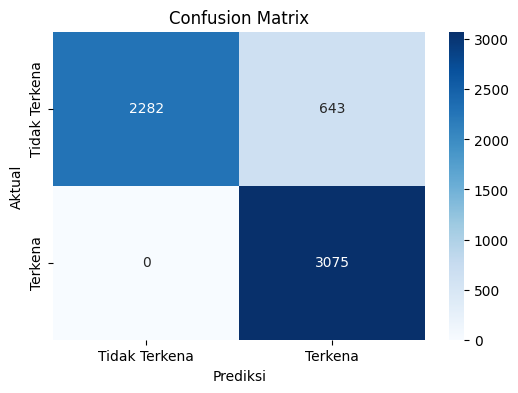

In [28]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Tidak Terkena', 'Terkena'], yticklabels=['Tidak Terkena', 'Terkena'])
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix')
plt.show()

*ROC AUC*

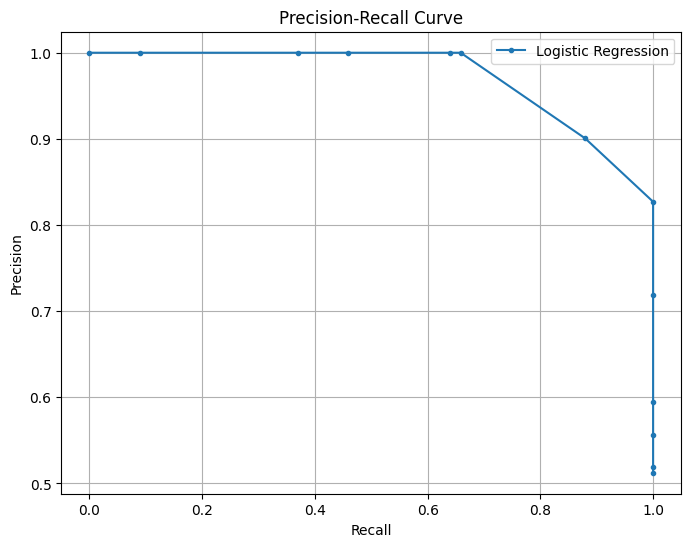

In [29]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Logistic Regression')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title("Precision-Recall Curve")
plt.grid()
plt.show()

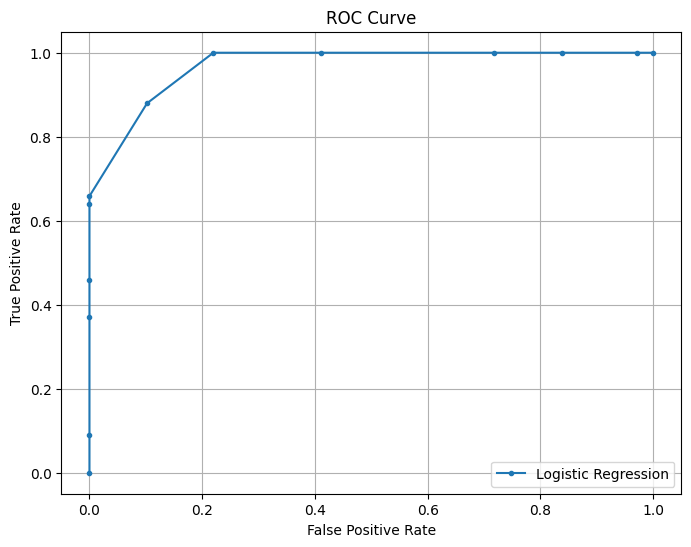

In [30]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='.', label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title("ROC Curve")
plt.grid()
plt.show()

1.	Apa saja variabel yang paling signifikan dalam memprediksi penyakit paru-paru menggunakan algoritma logistic regression?

<ipython-input-31-0bf496d9dd58>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coefficients['Koefisien'], y=coefficients['Fitur'], palette='viridis')


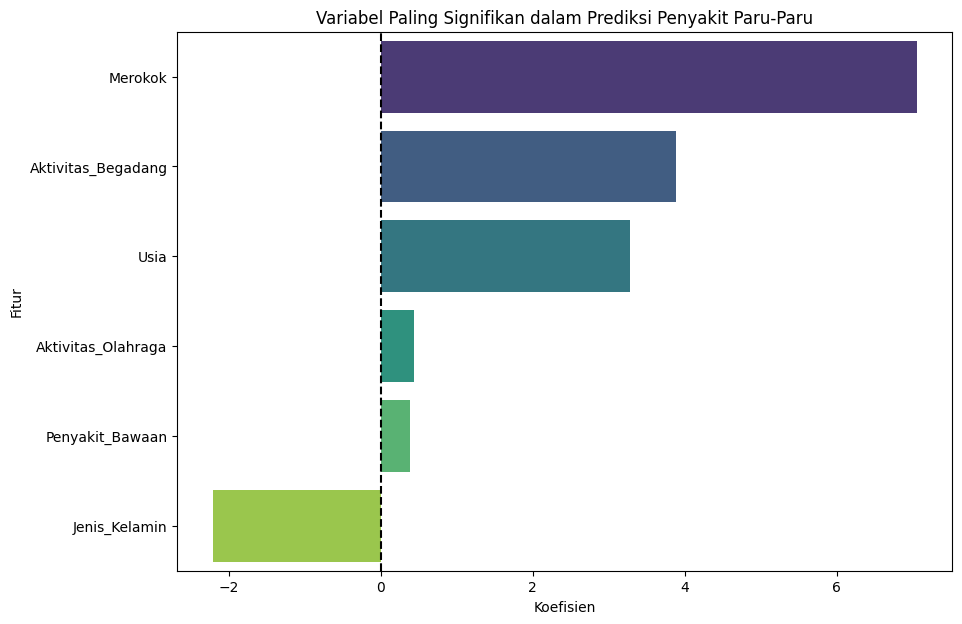

In [31]:
# Visualisasi Variabel Paling Signifikan (Koefisien Model)
coefficients = pd.DataFrame({'Fitur': X.columns, 'Koefisien': logistic_model.coef_[0]})
coefficients = coefficients.sort_values(by='Koefisien', ascending=False)
plt.figure(figsize=(10,7))
sns.barplot(x=coefficients['Koefisien'], y=coefficients['Fitur'], palette='viridis')
plt.axvline(0, color='black', linestyle='--')
plt.xlabel('Koefisien')
plt.ylabel('Fitur')
plt.title('Variabel Paling Signifikan dalam Prediksi Penyakit Paru-Paru')
plt.show()

3.	Bagaimana pengaruh penyakit bawaan terhadap kemungkinan seseorang menderita penyakit paru-paru?

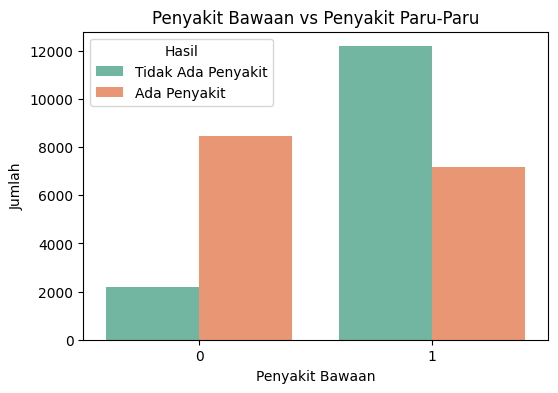

In [32]:
# Bar plot for Penyakit_Bawaan vs Hasil
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Penyakit_Bawaan', hue='Hasil', palette='Set2')
plt.title('Penyakit Bawaan vs Penyakit Paru-Paru')
plt.xlabel('Penyakit Bawaan')
plt.ylabel('Jumlah')
plt.legend(title='Hasil', labels=['Tidak Ada Penyakit', 'Ada Penyakit'])
plt.show()
# Tambahkan nilai di atas setiap bar
for p in ax.patches:
  ax.annotate(f'{int(p.get_height())}',
  (p.get_x() + p.get_width() / 2., p.get_height()),
  ha='center', va='bottom', fontsize=6, color='black', fontweight='bold')

Kelas 1: 15648 baris (52.2%)
Kelas 0: 14352 baris (47.8%)


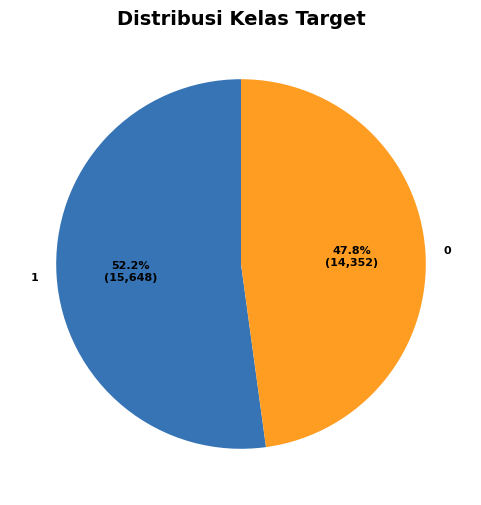

In [33]:
import matplotlib.pyplot as plt

# Hitung distribusi kelas
class_counts = y.value_counts()
total_samples = len(y)  # Total jumlah baris

# Buat pie chart
plt.figure(figsize=(6, 6))
wedges, texts, autotexts = plt.pie(
    class_counts,
    labels=class_counts.index,
    autopct=lambda p: '{:.1f}%\n({:,.0f})'.format(p, p * sum(class_counts) / 100),  # Persentase + jumlah
    colors=['#3674B5','#FF9D23'],
    startangle=90,
    textprops={'fontsize': 8, 'weight': 'bold'}
)

# Tambahkan judul
plt.title("Distribusi Kelas Target", fontsize=14, fontweight='bold')

# Tambahkan jumlah baris per kelas di luar chart
for i, (label, count) in enumerate(class_counts.items()):
    print(f"Kelas {label}: {count} baris ({(count/total_samples)*100:.1f}%)")

# Tampilkan pie chart
plt.show()

**SAVE MODEL**

In [36]:
# Simpan model menggunakan joblib
joblib.dump(logistic_model, "logistic_regression_model.sav")
print("✅ Model berhasil disimpan!")

✅ Model berhasil disimpan!
